# Deep Learning
## Assignment 3
Previously in 2_fullyconnected.ipynb, you trained a logistic regression and a neural network model.
The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline 


First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [5]:
## Define a measure of Accuracy for Predictions and Labels
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
batch_size = 128

sd = 1.0 / np.sqrt(batch_size)

num_hidden_units1 = 1024
num_hidden_units2 = 512
learning_rate = 0.5

graph = tf.Graph()
with graph.as_default():
    with tf.device('/cpu:0'):   # Forcing on CPU (as TF is complaining of GPU out of mem)
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        #X = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size)) # Features
        #Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))   # labels
        
        tf_train_dataset = tf.placeholder( tf.float32, 
                                         shape=(batch_size, image_size*image_size))
        tf_train_labels  = tf.placeholder( tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset  = tf.constant(test_dataset)
        
        beta = tf.placeholder(tf.float32)   # param for Regularization
        keep_prob = tf.placeholder(tf.float32)   # for drop out
        
        # Variables
        W1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_units1], 
                                            mean=0, stddev=np.sqrt(2.0/(image_size*image_size))))
        b1 = tf.Variable(tf.zeros([num_hidden_units1]))
        
        W2 = tf.Variable(tf.truncated_normal([num_hidden_units1, num_hidden_units2], 
                                            mean=0, stddev=np.sqrt(2.0/num_hidden_units1)))
        b2 = tf.Variable(tf.zeros([num_hidden_units2]))
        
        # final weights
        W  = tf.Variable(tf.truncated_normal([num_hidden_units2, num_labels], 
                                            mean=0, stddev=np.sqrt(2.0/num_hidden_units2)))
        b  = tf.Variable(tf.zeros([num_labels]))
        
        def model(data):  
            """ Assembles the model, using given dataset
            Return h = X . W + b
            """
            h1 = tf.nn.relu(tf.matmul(data,  W1) + b1)
            h1 = tf.nn.dropout(h1, keep_prob)     # Dropout
            h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
            #h2 = tf.nn.dropout(h2, keep_prob)      # Dropout
            return tf.matmul(h2, W) + b
        
        
        logits = model(tf_train_dataset)    # for Training dataset
        #y_     = tf.nn.softmax(logits)   # scaled logits, after softmax
        
        # Loss calc - on Training
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
                 beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W))
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
        
        # predictions
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset))  # eval on Validation
        test_prediction  = tf.nn.softmax(model(tf_test_dataset))   # eval on Test data
        

In [6]:
num_steps = 5001
beta_fixed = 1e-3
keep_prob_train = 0.5
keep_prob_test = 1.0

cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None

## For limiting GPU memory usage: 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print ("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a mini batch
        batch_data   = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels [offset:(offset + batch_size), :]
        # Make a dict telling the session where to find the minibatch
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: beta_fixed,    
                     keep_prob: keep_prob_train}    
        # run one step
        _, step_loss, predictions = session.run([optimizer, loss, train_prediction], 
                                        feed_dict=feed_dict)
        cost_history = np.append(cost_history, step_loss)   # save the loss
        
        if (step % 500 == 0):
            print ("minibatch loss at step %d: %f" % (step, step_loss))
            print ("minibatch acc : %.1f%%" % accuracy(predictions, batch_labels))
            print ("validation acc: %.1f%%" % accuracy(valid_prediction.eval(feed_dict={
                                                                 keep_prob: keep_prob_test}), 
                                                valid_labels))
    
    print ("Test accuracy : %.1f%%" % accuracy(test_prediction.eval(feed_dict={
                                                                   keep_prob: keep_prob_test}),
                                                test_labels))
    

Initialized
minibatch loss at step 0: 3.659582
minibatch acc : 7.0%
validation acc: 27.0%
minibatch loss at step 500: 1.177359
minibatch acc : 90.6%
validation acc: 85.1%
minibatch loss at step 1000: 1.056028
minibatch acc : 82.8%
validation acc: 85.5%
minibatch loss at step 1500: 0.673375
minibatch acc : 89.8%
validation acc: 86.8%
minibatch loss at step 2000: 0.593424
minibatch acc : 92.2%
validation acc: 87.3%
minibatch loss at step 2500: 0.624670
minibatch acc : 87.5%
validation acc: 86.9%
minibatch loss at step 3000: 0.645932
minibatch acc : 84.4%
validation acc: 87.4%
minibatch loss at step 3500: 0.656286
minibatch acc : 86.7%
validation acc: 87.4%
minibatch loss at step 4000: 0.501366
minibatch acc : 87.5%
validation acc: 87.6%
minibatch loss at step 4500: 0.503272
minibatch acc : 89.1%
validation acc: 87.1%
minibatch loss at step 5000: 0.545159
minibatch acc : 88.3%
validation acc: 87.7%
Test accuracy : 93.8%


In [5]:
#Trying with Learning Rate Schedule

In [6]:
batch_size = 128

sd = 1.0 / np.sqrt(batch_size)

num_hidden_units1 = 1024
num_hidden_units2 = 512
learning_rate = 0.5

graph = tf.Graph()
with graph.as_default():
    with tf.device('/cpu:0'):   # Forcing on CPU (as TF is complaining of GPU out of mem)
        # Input data. For the training data, we use a placeholder that will be fed
        # at run time with a training minibatch.
        #X = tf.placeholder(tf.float32, shape=(batch_size, image_size*image_size)) # Features
        #Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))   # labels
        
        tf_train_dataset = tf.placeholder( tf.float32, 
                                         shape=(batch_size, image_size*image_size))
        tf_train_labels  = tf.placeholder( tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset  = tf.constant(test_dataset)
        
        beta = tf.placeholder(tf.float32)   # param for Regularization
        keep_prob = tf.placeholder(tf.float32)   # for drop out
        global_step = tf.Variable(0)
        
        
        # Variables
        W1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_hidden_units1], 
                                            mean=0, stddev=np.sqrt(2.0/(image_size*image_size))))
        b1 = tf.Variable(tf.zeros([num_hidden_units1]))
        
        W2 = tf.Variable(tf.truncated_normal([num_hidden_units1, num_hidden_units2], 
                                            mean=0, stddev=np.sqrt(2.0/num_hidden_units1)))
        b2 = tf.Variable(tf.zeros([num_hidden_units2]))
        
        # final weights
        W  = tf.Variable(tf.truncated_normal([num_hidden_units2, num_labels], 
                                            mean=0, stddev=np.sqrt(2.0/num_hidden_units2)))
        b  = tf.Variable(tf.zeros([num_labels]))
        
        def model(data):  
            """ Assembles the model, using given dataset
            Return h = X . W + b
            """
            h1 = tf.nn.relu(tf.matmul(data,  W1) + b1)
            h1 = tf.nn.dropout(h1, keep_prob)     # Dropout
            h2 = tf.nn.relu(tf.matmul(h1, W2) + b2)
            #h2 = tf.nn.dropout(h2, keep_prob)      # Dropout
            return tf.matmul(h2, W) + b
        
        
        logits = model(tf_train_dataset)    # for Training dataset
        #y_     = tf.nn.softmax(logits)   # scaled logits, after softmax
        
        # Loss calc - on Training
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + \
                 beta * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W))
            
        learning_rate = tf.train.exponential_decay(0.5, global_step, 2000, 0.65, staircase=True)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
        
        # predictions
        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(model(tf_valid_dataset))  # eval on Validation
        test_prediction  = tf.nn.softmax(model(tf_test_dataset))   # eval on Test data
        

In [7]:
num_steps = 8001
beta_fixed = 1e-3
keep_prob_train = 0.5
keep_prob_test = 1.0

cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None

## For limiting GPU memory usage: 
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print ("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a mini batch
        batch_data   = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels [offset:(offset + batch_size), :]
        # Make a dict telling the session where to find the minibatch
        feed_dict = {tf_train_dataset: batch_data,
                     tf_train_labels: batch_labels,
                     beta: beta_fixed,    
                     keep_prob: keep_prob_train}    
        # run one step
        _, step_loss, predictions = session.run([optimizer, loss, train_prediction], 
                                        feed_dict=feed_dict)
        cost_history = np.append(cost_history, step_loss)   # save the loss
        
        if (step % 500 == 0):
            print ("minibatch loss at step %d: %f" % (step, step_loss))
            print ("minibatch acc : %.1f%%" % accuracy(predictions, batch_labels))
            print ("validation acc: %.1f%%" % accuracy(valid_prediction.eval(feed_dict={
                                                                 keep_prob: keep_prob_test}), 
                                                valid_labels))
    
    print ("Test accuracy : %.1f%%" % accuracy(test_prediction.eval(feed_dict={
                                                                   keep_prob: keep_prob_test}),
                                                test_labels))
    

Initialized
minibatch loss at step 0: 3.599866
minibatch acc : 9.4%
validation acc: 23.2%
minibatch loss at step 500: 1.179434
minibatch acc : 89.8%
validation acc: 84.9%
minibatch loss at step 1000: 1.066988
minibatch acc : 82.8%
validation acc: 86.0%
minibatch loss at step 1500: 0.689836
minibatch acc : 90.6%
validation acc: 86.7%
minibatch loss at step 2000: 0.595683
minibatch acc : 92.2%
validation acc: 87.3%
minibatch loss at step 2500: 0.583258
minibatch acc : 88.3%
validation acc: 87.5%
minibatch loss at step 3000: 0.617804
minibatch acc : 85.9%
validation acc: 87.6%
minibatch loss at step 3500: 0.656064
minibatch acc : 82.8%
validation acc: 88.0%
minibatch loss at step 4000: 0.513816
minibatch acc : 91.4%
validation acc: 88.2%
minibatch loss at step 4500: 0.486565
minibatch acc : 87.5%
validation acc: 88.1%
minibatch loss at step 5000: 0.524385
minibatch acc : 90.6%
validation acc: 88.8%
minibatch loss at step 5500: 0.558334
minibatch acc : 87.5%
validation acc: 88.6%
minibatch

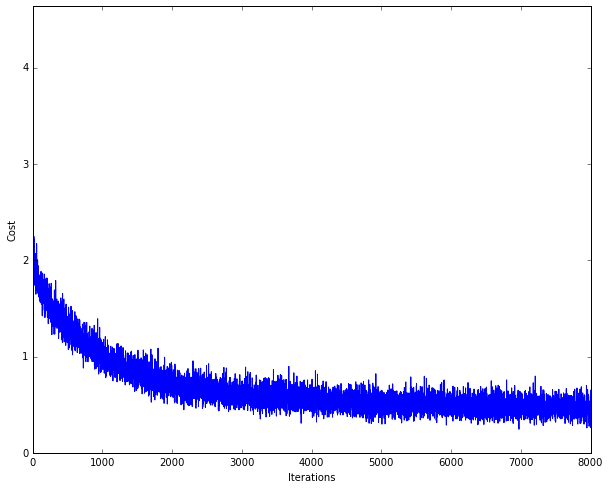

In [8]:
%matplotlib inline 

fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,num_steps,0,np.max(cost_history)])
plt.show()
